In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split 

In [190]:
ratings_df = pd.read_csv('ratings_matrix.csv')
ratings_df.head()

,User_id,"""Chosen"" Classics: Round the World in Eighty Days","""D"" is for Deadbeat","""Mildred Pierce","""Ra Force Rising"": Brother G","""Thirty years in hell""; or, ""From darkness to light",'Tis The Season: The Choice\First Fruits\A New Year; A New Beginning,'Tis the Season to Be Murdered,... Summer moonshine,...Arrow pointing nowhere,...,Zane's Gettin' Buck Wild: Sex Chronicles II,Zane's Skyscraper: A Novel,Zazie dans le Mtro,Zen Attitude,Zia,Zorba the Greek,green valley,never too much,our davie pepper,the Picture of Dorian Gray
0,A106016KSI0YQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A106E1N0ZQ4D9W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A10T0OW97SFBB,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A10Y3OZWENAQ6W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A1129LM24YWSZV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
#replace missing ratings with Nan
ratings_df.fillna(0, inplace=True)
#save user and title information
users = ratings_df['User_id']
titles = ratings_df.columns[1:]
#matrix to be passed to the autoencoder
ratings_matrix = ratings_df.drop('User_id',axis=1).values
#transpose to make item based matrix
ratings_matrix = ratings_matrix.T
ratings_matrix.shape

(2135, 1066)

In [192]:
#train test split
train_matrix, test_matrix = train_test_split(ratings_matrix, test_size=0.1, random_state=1992)
print(train_matrix.shape, test_matrix.shape)

(1921, 1066) (214, 1066)


In [193]:
def subtract_biases(X):
    X_centered = X.copy()
    biases = []
    for i in range(X.shape[0]):
        row = X[i]
        nonzero_mask = row != 0
        #only do if non-zero entries in the row
        if np.any(nonzero_mask): 
            bias = row[nonzero_mask].mean()
            biases.append(bias)
            X_centered[i, nonzero_mask] = row[nonzero_mask] - bias

    return X_centered, biases


In [194]:
train_matrix, train_biases = subtract_biases(train_matrix)

test_matrix, test_biases = subtract_biases(test_matrix)

In [195]:
#masked mse loss function
def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    squared_error = tf.square(y_true - y_pred)
    masked_se = mask * squared_error
    #average over non-zero entries
    return tf.reduce_sum(masked_se) / tf.reduce_sum(mask)

### Autoencoder Architecture
Used this paper for regularizer, dropout, and re-feeding ideas:
<Link Text>https://dl.acm.org/doi/10.1145/2740908.2742726 <br>

In [196]:
original_dim = ratings_matrix.shape[1]
encoding_dim = 256

#input layer: user rating vector
input_layer = layers.Input(shape=(original_dim,))

#encoded layer
encoded = layers.Dense(encoding_dim, activation='selu', kernel_regularizer=regularizers.l2(0.0001), 
                       activity_regularizer=regularizers.l1(0.0001))(input_layer)

#decoder
output_layer = layers.Dense(original_dim, activation='linear')(encoded) 

#model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

#compile the model
autoencoder.compile(optimizer='adam', loss= masked_mse)

In [197]:
autoencoder.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 1066)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       273,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1066)           │       273,962 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 547,114 (2.09 MB)

 Trainable params: 547,114 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

In [198]:
#train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(train_matrix, train_matrix, epochs=500, batch_size=128, shuffle=True,
                          validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.3685 - val_loss: 1.2318
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0875 - val_loss: 1.1039
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9197 - val_loss: 1.0095
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7877 - val_loss: 0.9388
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7093 - val_loss: 0.8838
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6460 - val_loss: 0.8400
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5915 - val_loss: 0.8048
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5556 - val_loss: 0.7751
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5233 - val_loss: 0.7496
Epoch 10/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4892 - val_loss: 0.7271
Epoch 11/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4708 - val_loss: 0.7074
Epoch 12/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

### Plot the training/validation loss curves

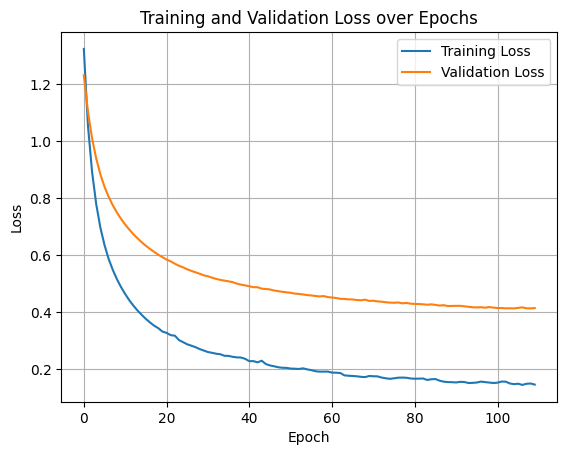

In [200]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [214]:
autoencoder.save('final_model.keras')

#### Check the test loss
better

In [226]:
#loss without regularization penalty
test_reconstruction = autoencoder.predict(test_matrix)
pred_test_tensor = tf.convert_to_tensor(test_reconstruction, dtype=tf.float32)

true_test_tensor = tf.convert_to_tensor(test_matrix, dtype=tf.float32)

test_loss = masked_mse(true_test_tensor,pred_test_tensor)

print(f'Test Loss: {test_loss.numpy():.4f}')
print(f'+/- {np.sqrt(test_loss):.4f} from true rating')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Loss: 0.2453
+/- 0.4953 from true rating


In [225]:
#loss with regularization penalty
autoencoder.evaluate(true_test_tensor, pred_test_tensor)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0463 


0.044397126883268356

In [177]:
reconstruction_matrix = autoencoder.predict(train_matrix)
#scale back
reconstruction_matrix = (reconstruction_matrix + np.array([train_biases]).T)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [178]:
print(reconstruction_matrix.shape)
print(reconstruction_matrix[0:5,:])
print(f'range of reconstructed ratings: {reconstruction_matrix.min()} - {reconstruction_matrix.max()}')

(1921, 1066)
[[3.7285405  3.76866854 3.9319498  ... 3.81183433 3.64369712 4.00613359]
 [4.17593379 4.02516184 4.0580831  ... 4.7080755  4.17550641 4.75454853]
 [4.17661026 4.39075761 4.47201862 ... 4.649266   4.31737248 4.44333509]
 [4.47138833 4.69513826 4.93716778 ... 4.97944795 4.57432865 5.04434045]
 [4.3702164  4.68382706 4.72110318 ... 4.76286486 4.61421844 4.72583498]]
range of reconstructed ratings: -0.3591189876435297 - 6.668385401874984


### Make recommendations
Certain items are recommended alot

In [231]:

#number of items to recommend
top_k = 10
#zero out previously rated items, so they are not recommended
#rated_indices = np.argwhere(test_matrix)
#rows, columns = rated_indices.T
#reconstruction_matrix[rows,columns] = 0

#transpose to get user based matrix
reconstruction_matrix=reconstruction_matrix.T
#get random user
rand_num = np.random.randint(reconstruction_matrix.shape[0],size=1)
user = reconstruction_matrix[rand_num,:]
#make recommendations
recs = np.argsort(-user)[0,0:top_k]
print(rand_num)
print(recs)
print(titles[recs])
print(f'\npredicted ratings: {user[0,recs]}')

[180]
[126 712 475 105 750 991 611 718 522 296]
Index(['Am I a Hindu? The Hinduism Primer',
       'Hildegarde Withers: Uncollected Riddles',
       'Dream Angus: The Celtic God of Dreams', 'Against His Will',
       'I Bow to Thee, My Country', 'Mansfield Park', 'From Potter's Field',
       'His Inconvenient Wife: An Inconvenient Marriage', 'Empress Bianca',
       'Cactus Thorn'],
      dtype='object')

predicted ratings: [5.34160344 5.17884366 5.15346394 5.13164632 5.11014454 5.0884289
 5.08376209 5.08158497 5.06153469 5.05659138]


### Find items with highest predicted ratings

In [232]:
top_k=10
average_scores = reconstruction_matrix.mean(axis=0)
recs = np.argsort(-average_scores)[0:top_k]
print(f'Recommended Items: {recs}')
print(f'Predicted Ratings: {average_scores[recs]}')

book_recs = titles[recs]
print(f'Recommended Items: {book_recs}')

Recommended Items: [  35  731  538  170  663  830  897  241 1001  800]
Predicted Ratings: [4.67295981 4.62962274 4.62716924 4.60565486 4.592475   4.58316303
 4.57959062 4.5533269  4.54572773 4.54474506]
Recommended Items: Index(['A Farewell to Arms', 'Hot Flash Holidays',
       'Everyman's Library #217: Midnight's Children',
       'Arsene Lupin Vs. Herlock Sholmes: A Classic Tale of the World's Greatest Thief and the World's Greatest Detective!',
       'Gypsy at Almack's', 'John L. Byrne's Fear Book',
       'Last Stand at Papago Wells', 'Bittersweet Rain',
       'Master of Glen Crannach', 'Ironic'],
      dtype='object')
